In [1]:
import numpy as np
import math 
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import gamma
#from itertools import combinations_with_replacement
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import kpss

/Users/antoine/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# Generation GARCH process

Generation of the $GARCH(1,1)-\mathcal{T}(6)$ process

The size of training sample is 4000 and size of test sample is 4000


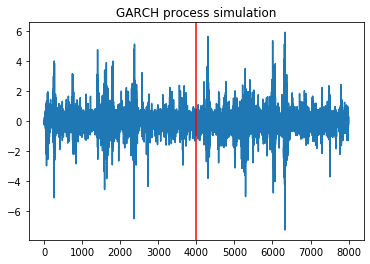

In [2]:
def simulated_GARCH(n,w=0.01,alpha=0.13,beta=0.86):
    h = [0]
    y = [0]
    for i in range(1,n):
        h.append(w + alpha * pow(y[i-1],2)  + beta * h[i-1])
        y.append(math.sqrt( h[i] * 4 / 6 ) * stats.t.rvs(6))
    return y

y = simulated_GARCH(n=8000)
plt.plot(y)
plt.title("GARCH process simulation")
plt.axvline(x=4000,color='red')
y_in_sample = y[:4000]
y_out_sample = y[4000:]
print('The size of training sample is',len(y_in_sample),'and size of test sample is',len(y_out_sample))

## Density of observations

We check quickly the histogram of observations and compare it to a $\mathcal{N}(0,1)$ sample

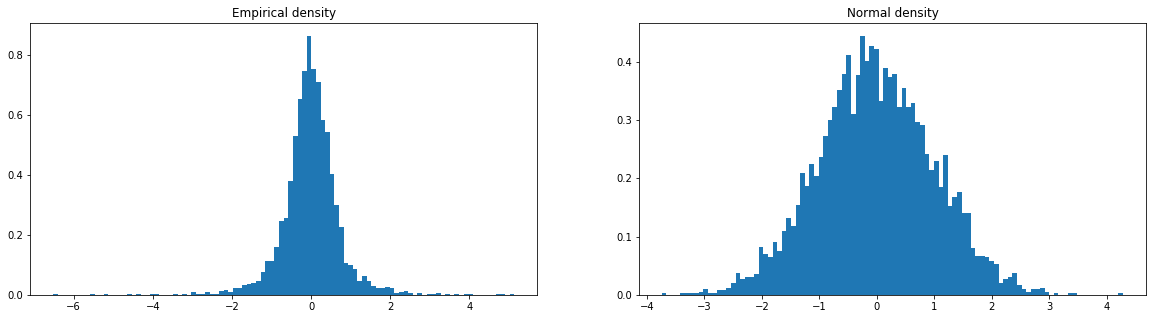

In [3]:
_, (ax1, ax2) = plt.subplots(1, 2 , figsize=(20,5))
ax1.hist(y_in_sample,bins=100,density=True)
ax1.title.set_text("Empirical density")
ax2.hist(np.random.normal(0,1,5000), bins=100, density=True)
ax2.title.set_text("Normal density")

## First try with $\mathcal{N}(0,1)$ iid

To etablish the benchmark we first evaluate forecasts based on a naive assumption that the process is $\textit{iid}$ $\mathcal{N}(0,1)$

In [4]:
z = []
for i in range(len(y_out_sample)):
    z.append(stats.norm.cdf(y_out_sample[i]))

<Figure size 432x288 with 0 Axes>

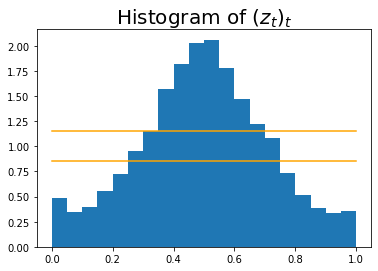

<Figure size 432x288 with 0 Axes>

In [5]:
plt.hist(z,bins=20,density=True)
plt.plot([0,1],[1.15,1.15] , color = 'orange')
plt.plot([0,1],[0.85,0.85] , color = 'orange')
plt.title("Histogram of $(z_t)_t$",size=20)
plt.figure()

In [6]:
z_test = z
stats.kstest(z_test,stats.uniform.cdf)

KstestResult(statistic=0.13451360561426184, pvalue=2.73116231880404e-63)

The Kolmogorov-Test is usefull to test $H_0$: The sample follows a uniform law. Here $H_0$ is clearly rejected


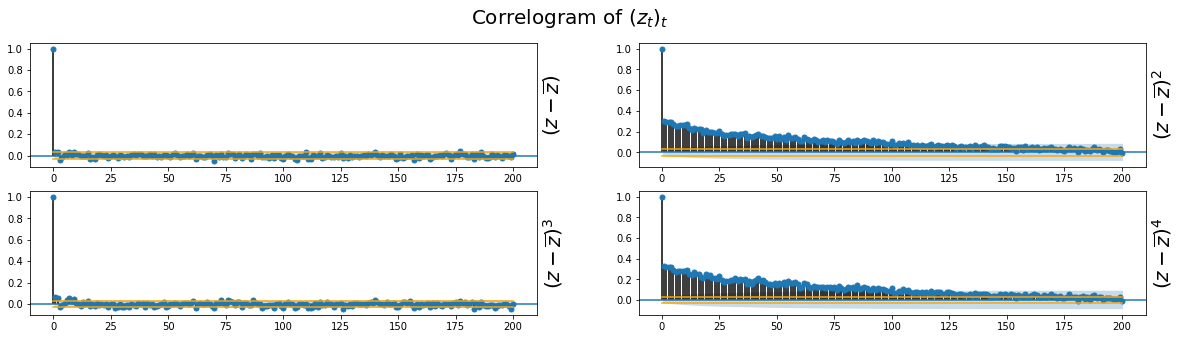

In [7]:
z_mean = sum(z)/len(z)
z1 = z-z_mean
z2 = pow(z-z_mean,2)
z3 = pow(z-z_mean,3)
z4 = pow(z-z_mean,4)
fig,ax = plt.subplots(nrows = 2, ncols = 2,figsize=(20,5))
plt.suptitle('Correlogram of $(z_t)_t$',size=20)
plot_acf(z1,lags=200,ax=ax[0,0],title="")
ax[0,0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0,0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[0,0].set_ylabel('$(z- \overline{z})$', fontsize = 20 )#ylabel
ax[0,0].yaxis.set_label_position("right")
plot_acf(z2,lags=200,ax=ax[0,1],title="")
ax[0,1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0,1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[0,1].set_ylabel('$(z- \overline{z})^2$', fontsize = 20 )#ylabel
ax[0,1].yaxis.set_label_position("right")
plot_acf(z3,lags=200,ax=ax[1,0],title="")
ax[1,0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1,0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[1,0].set_ylabel('$(z- \overline{z})^3$', fontsize = 20 )#ylabel
ax[1,0].yaxis.set_label_position("right")
plot_acf(z4,lags=200,ax=ax[1,1],title="")
ax[1,1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1,1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[1,1].set_ylabel('$(z- \overline{z})^4$', fontsize = 20 )#ylabel
ax[1,1].yaxis.set_label_position("right")
plt.show()

As expected the volatility is not captured

In [8]:
print(acorr_ljungbox(z1,lags=[10],return_df=True))
print(acorr_ljungbox(z2,lags=[10],return_df=True))
print(acorr_ljungbox(z3,lags=[10],return_df=True))
print(acorr_ljungbox(z4,lags=[10],return_df=True))

      lb_stat  lb_pvalue
10  30.238404   0.000783
        lb_stat  lb_pvalue
10  3024.877771        0.0
      lb_stat     lb_pvalue
10  63.892148  6.599237e-10
        lb_stat  lb_pvalue
10  3560.585146        0.0


The Ljung-Box Test is also usefull to test $H_0$: There is no auto-correlation of order($k$). Here again it's clearly rejected

 # No parametric density estimation
 
 ## Empiric cumulative distribution

In [9]:
from statsmodels.distributions.empirical_distribution import ECDF

In [10]:
ecdf = ECDF(y_in_sample)

In [11]:
z = []
for i in range(len(y_out_sample)):
    z.append(ecdf(y_out_sample[i]))

<Figure size 432x288 with 0 Axes>

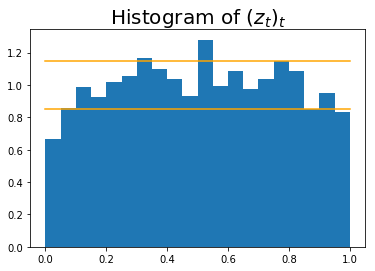

<Figure size 432x288 with 0 Axes>

In [12]:
plt.hist(z,bins=20,density=True)
plt.plot([0,1],[1.15,1.15] , color = 'orange')
plt.plot([0,1],[0.85,0.85] , color = 'orange')
plt.title("Histogram of $(z_t)_t$",size=20)
plt.figure()

In [13]:
z_test = z
stats.kstest(z_test,stats.uniform.cdf)

KstestResult(statistic=0.03375, pvalue=0.0002152604652185325)

With the empiric cumulative distributionn we see that $(z_t)_t$ is uniformaly distributed with a $p-value$ of 0.15. But the problem is the auto-correlation for moment of order 2 and 4.

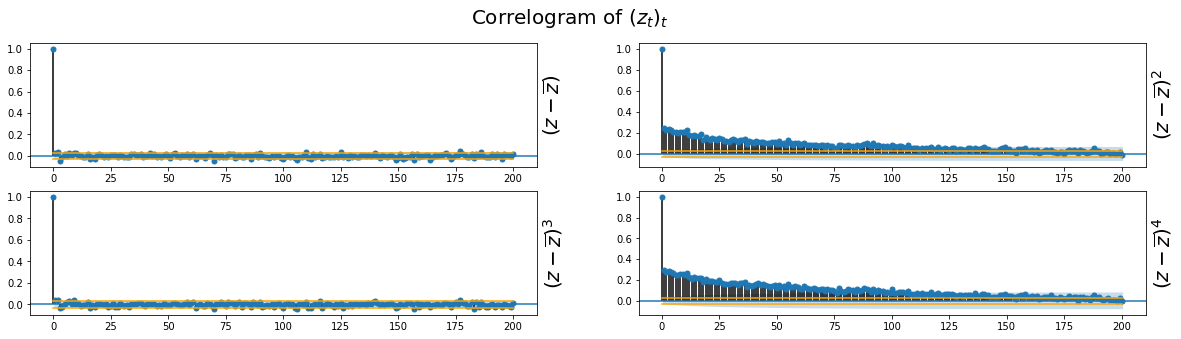

In [14]:
z_mean = sum(z)/len(z)
z1 = z-z_mean
z2 = pow(z-z_mean,2)
z3 = pow(z-z_mean,3)
z4 = pow(z-z_mean,4)
fig,ax = plt.subplots(nrows = 2, ncols = 2,figsize=(20,5))
plt.suptitle('Correlogram of $(z_t)_t$',size=20)
plot_acf(z1,lags=200,ax=ax[0,0],title="")
ax[0,0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0,0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[0,0].set_ylabel('$(z- \overline{z})$', fontsize = 20 )#ylabel
ax[0,0].yaxis.set_label_position("right")
plot_acf(z2,lags=200,ax=ax[0,1],title="")
ax[0,1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0,1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[0,1].set_ylabel('$(z- \overline{z})^2$', fontsize = 20 )#ylabel
ax[0,1].yaxis.set_label_position("right")
plot_acf(z3,lags=200,ax=ax[1,0],title="")
ax[1,0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1,0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[1,0].set_ylabel('$(z- \overline{z})^3$', fontsize = 20 )#ylabel
ax[1,0].yaxis.set_label_position("right")
plot_acf(z4,lags=200,ax=ax[1,1],title="")
ax[1,1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1,1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[1,1].set_ylabel('$(z- \overline{z})^4$', fontsize = 20 )#ylabel
ax[1,1].yaxis.set_label_position("right")
plt.show()

In [15]:
print(acorr_ljungbox(z1,lags=[10],return_df=True))
print(acorr_ljungbox(z2,lags=[10],return_df=True))
print(acorr_ljungbox(z3,lags=[10],return_df=True))
print(acorr_ljungbox(z4,lags=[10],return_df=True))

      lb_stat  lb_pvalue
10  26.451879   0.003178
        lb_stat  lb_pvalue
10  1903.711437        0.0
     lb_stat  lb_pvalue
10  34.29455   0.000165
        lb_stat  lb_pvalue
10  2867.917181        0.0


## Kernel estimation

We use a gaussian kernel with Scott rules

In [16]:
from scipy.stats.kde import gaussian_kde
from scipy.integrate import quad

<Figure size 432x288 with 0 Axes>

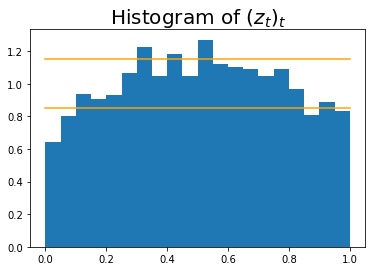

<Figure size 432x288 with 0 Axes>

In [17]:
kde = gaussian_kde(y_in_sample)
z = []
for i in range(len(y_out_sample)):
    res = kde.integrate_box_1d(-1000,y_out_sample[i])
    z.append(res)
plt.hist(z,bins=20,density=True)
plt.plot([0,1],[1.15,1.15] , color = 'orange')
plt.plot([0,1],[0.85,0.85] , color = 'orange')
plt.title("Histogram of $(z_t)_t$",size=20)
plt.figure()

In [18]:
z_test = z
stats.kstest(z_test,stats.uniform.cdf)

KstestResult(statistic=0.0428807779086153, pvalue=7.903867108953481e-07)

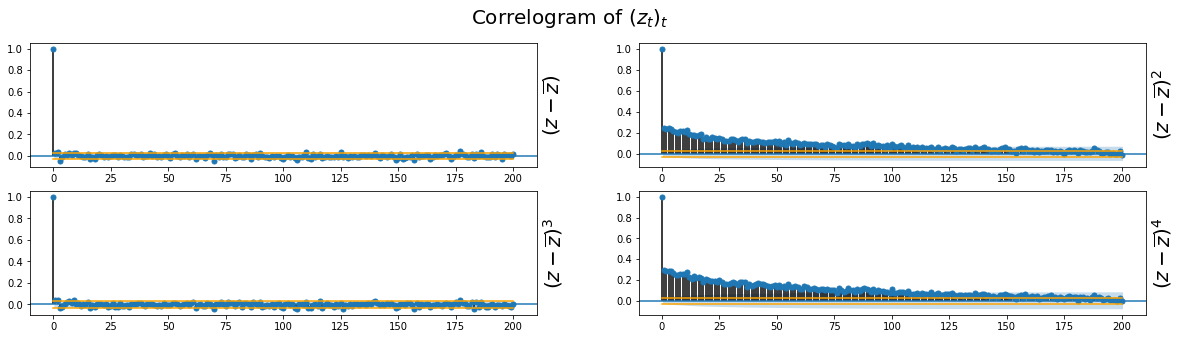

In [19]:
z_mean = sum(z)/len(z)
z1 = z-z_mean
z2 = pow(z-z_mean,2)
z3 = pow(z-z_mean,3)
z4 = pow(z-z_mean,4)
fig,ax = plt.subplots(nrows = 2, ncols = 2,figsize=(20,5))
plt.suptitle('Correlogram of $(z_t)_t$',size=20)
plot_acf(z1,lags=200,ax=ax[0,0],title="")
ax[0,0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0,0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[0,0].set_ylabel('$(z- \overline{z})$', fontsize = 20 )#ylabel
ax[0,0].yaxis.set_label_position("right")
plot_acf(z2,lags=200,ax=ax[0,1],title="")
ax[0,1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0,1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[0,1].set_ylabel('$(z- \overline{z})^2$', fontsize = 20 )#ylabel
ax[0,1].yaxis.set_label_position("right")
plot_acf(z3,lags=200,ax=ax[1,0],title="")
ax[1,0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1,0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[1,0].set_ylabel('$(z- \overline{z})^3$', fontsize = 20 )#ylabel
ax[1,0].yaxis.set_label_position("right")
plot_acf(z4,lags=200,ax=ax[1,1],title="")
ax[1,1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1,1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[1,1].set_ylabel('$(z- \overline{z})^4$', fontsize = 20 )#ylabel
ax[1,1].yaxis.set_label_position("right")
plt.show()

In [20]:
print(acorr_ljungbox(z1,lags=[10],return_df=True))
print(acorr_ljungbox(z2,lags=[10],return_df=True))
print(acorr_ljungbox(z3,lags=[10],return_df=True))
print(acorr_ljungbox(z4,lags=[10],return_df=True))

      lb_stat  lb_pvalue
10  26.368452   0.003275
        lb_stat  lb_pvalue
10  1989.009506        0.0
      lb_stat  lb_pvalue
10  34.931007   0.000128
       lb_stat  lb_pvalue
10  2932.52492        0.0


Same here with the Kernel-density estimation which gives even a better p-value, but it's still bot better for the ACF.

## Gaussian GARCH

In the goal to take into account the ACF effect, we use conditional times series processus as GARCH.

We start with a Gaussian-Garch(1,1) processus

In [21]:
alpha = 0.13
beta = 0.86
w = 1 - alpha - beta
nu = 10
ht = w + alpha * pow(y_out_sample[-1],2)
z = [stats.norm.cdf(y_out_sample[i],loc=0, scale=pow(ht,1/2))]
for i in range(1,len(y_out_sample)):
    ht = w + alpha * pow(y_out_sample[i-1],2) + beta * ht 
    z.append(stats.norm.cdf(y_out_sample[i],loc=0, scale=pow(ht,1/2)))

<Figure size 432x288 with 0 Axes>

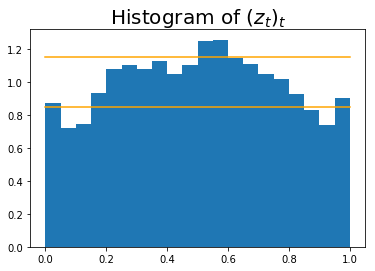

<Figure size 432x288 with 0 Axes>

In [22]:
plt.hist(z,bins=20,density=True)
plt.plot([0,1],[1.15,1.15] , color = 'orange')
plt.plot([0,1],[0.85,0.85] , color = 'orange')
plt.title("Histogram of $(z_t)_t$",size=20)
plt.figure()

In [23]:
z_test = z
stats.kstest(z_test,stats.uniform.cdf)

KstestResult(statistic=0.0391545763236191, pvalue=9.155877366089856e-06)

Now we see that with a Gaussian-GARCH(1,1) we take into account the correlation. Problem is now that the $(z_t)_t$ are not uniformaly distrubted, the p-value of KS-test is only $7e-4$

We can observe that on the histogram, there is too much $z_t$ around firstly 0.5 and secondly, the border 0 and 1. For 0.5 that mean that the chosen distribution of the GARCH has to much density in the center (around 0). And for 0 and 1 that means that the tail are underestimated

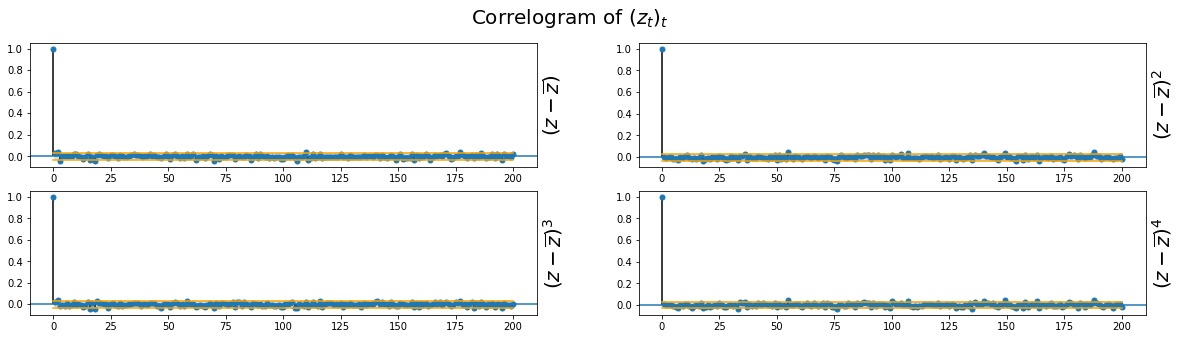

In [24]:
z_mean = sum(z)/len(z)
z1 = z-z_mean
z2 = pow(z-z_mean,2)
z3 = pow(z-z_mean,3)
z4 = pow(z-z_mean,4)
fig,ax = plt.subplots(nrows = 2, ncols = 2,figsize=(20,5))
plt.suptitle('Correlogram of $(z_t)_t$',size=20)
plot_acf(z1,lags=200,ax=ax[0,0],title="")
ax[0,0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0,0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[0,0].set_ylabel('$(z- \overline{z})$', fontsize = 20 )#ylabel
ax[0,0].yaxis.set_label_position("right")
plot_acf(z2,lags=200,ax=ax[0,1],title="")
ax[0,1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0,1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[0,1].set_ylabel('$(z- \overline{z})^2$', fontsize = 20 )#ylabel
ax[0,1].yaxis.set_label_position("right")
plot_acf(z3,lags=200,ax=ax[1,0],title="")
ax[1,0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1,0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[1,0].set_ylabel('$(z- \overline{z})^3$', fontsize = 20 )#ylabel
ax[1,0].yaxis.set_label_position("right")
plot_acf(z4,lags=200,ax=ax[1,1],title="")
ax[1,1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1,1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[1,1].set_ylabel('$(z- \overline{z})^4$', fontsize = 20 )#ylabel
ax[1,1].yaxis.set_label_position("right")
plt.show()

In [25]:
print(acorr_ljungbox(z1,lags=[10],return_df=True))
print(acorr_ljungbox(z2,lags=[10],return_df=True))
print(acorr_ljungbox(z3,lags=[10],return_df=True))
print(acorr_ljungbox(z4,lags=[10],return_df=True))

      lb_stat  lb_pvalue
10  19.513279   0.034207
     lb_stat  lb_pvalue
10  6.295829   0.789827
     lb_stat  lb_pvalue
10  14.64726   0.145461
     lb_stat  lb_pvalue
10  6.311453   0.788453


## t-GARCH

Now we use a Student-GARCH(1,1) processus to capture more the tails with 6 degrees of freedom

In [26]:
alpha = 0.13
beta = 0.86
w = 1 - alpha - beta
nu = 6
ht = w + alpha * pow(y_out_sample[-1],2)
z = [stats.t.cdf(y_out_sample[0] * math.sqrt(nu/(ht*(nu-2))),nu)]
for i in range(1,len(y_out_sample)):
    ht = w + alpha * pow(y_out_sample[i-1],2) + beta * ht 
    z.append(stats.t.cdf(y_out_sample[i] * math.sqrt(nu/(ht*(nu-2))),nu))

<Figure size 432x288 with 0 Axes>

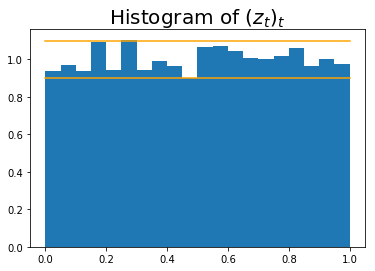

<Figure size 432x288 with 0 Axes>

In [27]:
plt.hist(z,bins=20,density=True)
plt.plot([0,1],[1.1,1.1] , color = 'orange')
plt.plot([0,1],[0.9,0.9] , color = 'orange')
plt.title("Histogram of $(z_t)_t$",size=20)
plt.figure()

In [28]:
z_test = z
stats.kstest(z_test,stats.uniform.cdf)

KstestResult(statistic=0.010784484783546822, pvalue=0.7365573077653309)

Now we see that the uniform test is better ($p-value$ of 0.59), and the ACF remains good.

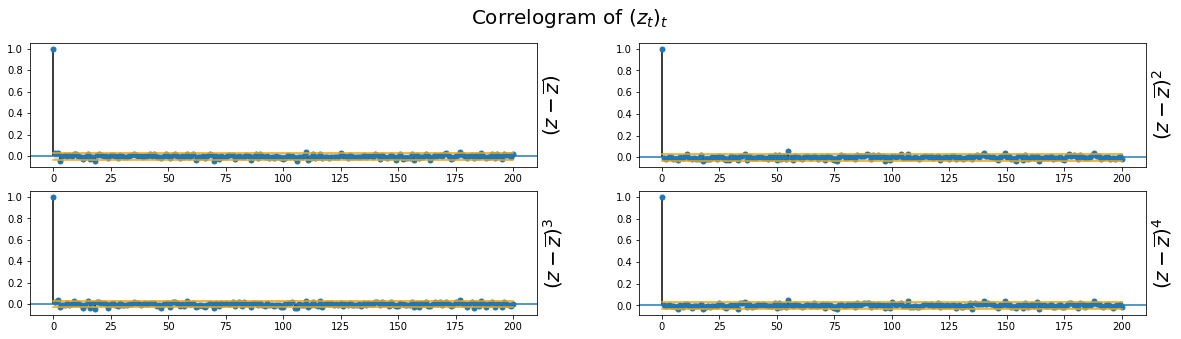

In [29]:
z_mean = sum(z)/len(z)
z1 = z-z_mean
z2 = pow(z-z_mean,2)
z3 = pow(z-z_mean,3)
z4 = pow(z-z_mean,4)
fig,ax = plt.subplots(nrows = 2, ncols = 2,figsize=(20,5))
plt.suptitle('Correlogram of $(z_t)_t$',size=20)
plot_acf(z1,lags=200,ax=ax[0,0],title="")
ax[0,0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0,0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[0,0].set_ylabel('$(z- \overline{z})$', fontsize = 20 )#ylabel
ax[0,0].yaxis.set_label_position("right")
plot_acf(z2,lags=200,ax=ax[0,1],title="")
ax[0,1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0,1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[0,1].set_ylabel('$(z- \overline{z})^2$', fontsize = 20 )#ylabel
ax[0,1].yaxis.set_label_position("right")
plot_acf(z3,lags=200,ax=ax[1,0],title="")
ax[1,0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1,0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[1,0].set_ylabel('$(z- \overline{z})^3$', fontsize = 20 )#ylabel
ax[1,0].yaxis.set_label_position("right")
plot_acf(z4,lags=200,ax=ax[1,1],title="")
ax[1,1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1,1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[1,1].set_ylabel('$(z- \overline{z})^4$', fontsize = 20 )#ylabel
ax[1,1].yaxis.set_label_position("right")
plt.show()

In [30]:
print(acorr_ljungbox(z1,lags=[10],return_df=True))
print(acorr_ljungbox(z2,lags=[10],return_df=True))
print(acorr_ljungbox(z3,lags=[10],return_df=True))
print(acorr_ljungbox(z4,lags=[10],return_df=True))

      lb_stat  lb_pvalue
10  20.369806   0.025943
    lb_stat  lb_pvalue
10  6.68669   0.754655
      lb_stat  lb_pvalue
10  16.093255   0.096994
     lb_stat  lb_pvalue
10  6.823665   0.741981


## Estimation of parameteres in the GARCH gaussian model

In this basic case, as we simulated the data we know what the parameters of our model. But when we figure out with real data, we don't know the law of observations, so we need to find what is the "best" model and how we find parameters of the model

For now we choose the model with respect to AIC Criteria and we esimate the parameters with gris-search. As it's a complex problem we don't want to use complex python's librairies for now

We define the log density of gaussian and student distribution, we'll need it for estimate the loglikelihood

In [31]:
def gaussian_logpdf(x,loc=0,scale=1):
    return -0.5 *(math.log(2 * math.pi * scale**2) +pow(x-loc,2)/scale**2)

def student_logpdf(x,nu,loc=0,scale=1):
    return math.log(gamma((nu+1)/2)) - math.log(gamma(nu/2)) -1/2 * math.log( math.pi * (scale**2) * nu )\
    - (nu+1)/2 * math.log(1+pow(x-loc,2)/((nu*scale**2)))

In [32]:
def garch_filter(w,alpha,beta,data):
    n = len(data)
    sigma_2 = np.zeros(n)
    sigma_2[0] = w/(1-alpha-beta) #set initalize variance equal to unconditional variance
    for i in range(n):
        sigma_2[i] = w + alpha * pow(data[i-1],2) + beta*sigma_2[i-1]
    return sigma_2

Then we define the function to compute the logelikelihood depends of the distribution

In [33]:
def minus_garch_loglikelihood(alpha,beta,data=y_in_sample,dist="gaussian",nu=6):
    
    n= len(data)
    w = 1 - alpha - beta
    
    sigma2 = garch_filter(w,alpha,beta,data)
    
    res = 0
    if dist=="gaussian":
        for i in range(n):
            scale_factor = pow(sigma2[i],1/2)
            res -= gaussian_logpdf(data[i],loc = 0, scale=scale_factor)
    if dist=='student':
        for i in range(n):
            scale_factor = pow(sigma2[i]*(nu-2)/nu,1/2)
            res -= student_logpdf(data[i], nu, loc = 0, scale = scale_factor)
    return res

We search the best parameters with a grid-search method

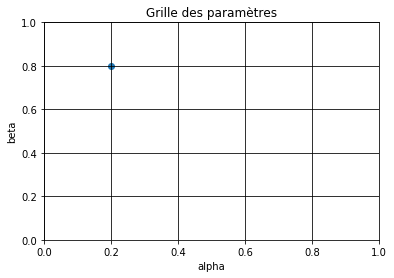

In [34]:
points = [0.2,0.8]

# x = list(map(lambda x: x[0], points))
# y = list(map(lambda x: x[1], points))

plt.rc('grid', linestyle="-", color='black')
plt.scatter([0.2], [0.8])
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("alpha")
plt.ylabel("beta")
plt.title("Grille des paramètres")
plt.grid(True)

plt.show()

In [42]:
#Maximzation of log likelihood by grid search
n=100
res = np.zeros((n,n))
best_loglikelihood,best_alpha,best_beta = np.inf,0,0
i,j = 0,0
alpha_scale = np.linspace(0.05,0.95,n)
beta_scale = np.linspace(0.05,0.95,n)
for alpha in alpha_scale:
    j=0
    for beta in beta_scale:
        if (alpha+beta >=1 or alpha+ beta <=0):
            res[i,j] = 0
        else:
            value = minus_garch_loglikelihood(alpha,beta,y_in_sample,dist='gaussian')
            res[i,j] = value
        if value < best_loglikelihood:
            best_alpha = alpha
            best_beta = beta
            best_loglikelihood = value
        j+=1
    i+=1
print("Best parameters we find on the grind search is omega=%0.2f, alpha=%0.2f, beta=%0.2f with a loglikelihood of %0.2f"%(1-best_alpha-best_beta,best_alpha,best_beta,best_loglikelihood))

Best parameters we find on the grind search is omega=0.01, alpha=0.12, beta=0.87 with a loglikelihood of 4153.92


We find parameters used for the simulation (which are $\alpha=0.13$ and $\beta=0.86$)

Utility function to plot the in 3rd, in the aim to observe the log likelihood regards to alpha and beta

In [36]:
def surface_plot (x_scale,y_scale,matrix):
    # x is cols, y is rows
    (x, y) = np.meshgrid(x_scale, y_scale)
    fig = plt.figure()
    ax = Axes3D(fig)
    surf = ax.plot_surface(x, y, matrix)
    return (fig, ax, surf)

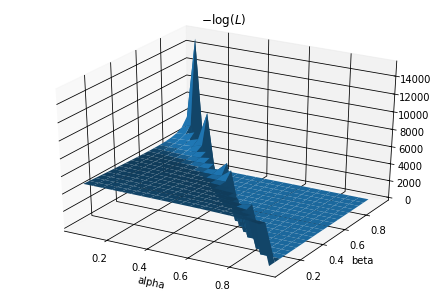

In [37]:
(fig, ax, surf) = surface_plot(alpha_scale,beta_scale,res)

plt.title("$-\log(L)$")
ax.set_xlabel('alpha')
ax.set_ylabel('beta')
#ax.set_zlabel('log likelihood')

plt.show()

As we see the log likelihood function is not convex and not linear, so we can't use usuals solvers for convex optimization.

## Estimation of parameteres in the GARCH student model

Now we do the same with a student distribution function. We also find best parameters with a grid search method

In [38]:
#Maximzation of log likelihood by grid search
n=100
res = np.zeros((n,n))
best_loglikelihood,best_alpha,best_beta = np.inf,0,0
i,j = 0,0
alpha_scale = np.linspace(0.01,2,n)
beta_scale = np.linspace(0.01,2,n)
for alpha in alpha_scale:
    j=0
    for beta in beta_scale:
        if (alpha+beta >=1 or alpha+ beta <=0):
            res[i,j] = 0
        else:
            value = minus_garch_loglikelihood(alpha,beta,y_in_sample,dist='student',nu=6)
            res[i,j] = value
        if value < best_loglikelihood:
            best_alpha = alpha
            best_beta = beta
            best_loglikelihood = value
        j+=1
    i+=1
print("Best parameters we find on the grind search is omega=%0.2f, alpha=%0.2f, beta=%0.2f with a loglikelihood of %0.2f"%(1-best_alpha-best_beta,best_alpha,best_beta,best_loglikelihood))

Best parameters we find on the grind search is omega=0.02, alpha=0.15, beta=0.83 with a loglikelihood of 4058.43


Here again, we almost find back the true parameters, the only problem is the computation time with this method which is pretty long. This method suffer from curse dimension, that mean for more than 5 parameters the computation time can be too big.

In order to solve this we will discuss later about a more optimal method to solve this, as we see the objective function log-likelihood looks concave in main regions, so we can use usual solver with "good" starting points

## Optimization library

We use Nelder-Mead optimization method to avoid as possible curse dimensionality. As the objective function (minus log-likelihood) is not convex we may want to use many starter point to avoid local minimums which are not global minimum

In [39]:
from scipy.optimize import minimize

In [40]:
def garch_loglikelihood(params,dist="gaussian",nu=6):
    
    data = y_in_sample
    
    n= len(data)
    w = params[0]
    alpha = params[1]
    beta = params[2]
    
    if w<=0:
        return np.inf
    
    if alpha+beta >=1:
        return np.inf
    
    sigma2 = garch_filter(w,alpha,beta,data)
    
    res = 0
    if dist=="gaussian":
        for i in range(n):
            scale_factor = pow(sigma2[i],1/2)
            res -= gaussian_logpdf(data[i],loc = 0, scale=scale_factor)
    if dist=='student':
        for i in range(n):
            scale_factor = pow(sigma2[i]*(nu-2)/nu,1/2)
            res -= student_logpdf(data[i], nu, loc = 0, scale = scale_factor)
    return res

In [41]:
res = minimize(garch_loglikelihood, x0=[0.1,0.1,0.6] , args ='student',method='Nelder-Mead')
print(res)

 final_simplex: (array([[0.00880371, 0.12978758, 0.86550092],
       [0.00879999, 0.12984886, 0.86544016],
       [0.00880664, 0.12972108, 0.8655254 ],
       [0.00879117, 0.12970385, 0.86558328]]), array([4054.21057617, 4054.21058348, 4054.21060223, 4054.21060639]))
           fun: 4054.2105761703765
       message: 'Optimization terminated successfully.'
          nfev: 147
           nit: 82
        status: 0
       success: True
             x: array([0.00880371, 0.12978758, 0.86550092])


We find the true parameters with this method way faster. We should compute the Nelder-Mead method with many starting point to avoid local minimum